# Game Prototype of Team Scotland #2
Felix Zaussinger, Martina Buck | 01.12.2020, 15:30

======================================================================================================================

                                            GAME CONFIGURATION

======================================================================================================================

**Magic commands**

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

**External imports**

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import configparser
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

**Figure properties**

In [3]:
sns.set_context("poster")
sns.set(rc={'figure.figsize': (8, 5)})
sns.set_style("ticks")

**Directory structure**

In [4]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "plots")
project_dir

'/Users/felix/ETH/code/gecm'

**Append project directory to PYTHONPATH via sys (!)**

Source: https://stackoverflow.com/questions/39299838/how-do-i-import-module-in-jupyter-notebook-directory-into-notebooks-in-lower-dir

In [5]:
if project_dir not in sys.path:
    sys.path.append(project_dir)

#### import our own code from src

In [6]:
from src.gecm.game import MatrixGame
from src.gecm import model, vis, io, game, base, dicts
from src.gecm.dicts import (
        original_lulc_mapping,
        lulc_remapping,
        simplified_lulc_mapping,
        simplified_lulc_mapping_colors
    )

#### Game parameters

In [7]:
# size of playing field in pixels
n_pixels = 80

# complexity of playing field (only granularity = 1 works for now)
granularity = 1

# colormap
simplified_lulc_cm = ListedColormap(
    [simplified_lulc_mapping_colors[x] for x in simplified_lulc_mapping_colors.keys()]
)

# path to raster data file (must be a geotiff)
fpath_map = os.path.join(
    data_processed, "NFI_rasterized_{}_{}.tif".format(n_pixels, n_pixels)
)

#### Configuration file

In [8]:
# init config file parser. methods: config.getboolean, config.getint, ... .
config = configparser.ConfigParser()
fpath_cf = os.path.join(project_dir, 'config.ini')
config.read(fpath_cf)

# Show configuration file sections
io.config_describe(config)


--- default ---
credentials: 'google_api_credentials.json'
scopes: https://www.googleapis.com/auth/spreadsheets.readonly

--- gdrive_spreadsheet_ids ---
spreadsheet_id_farmers: 1kEEcKdP__1XbYKe5-nVlxzAD_P5-EQx-23IAw9SXOoc
spreadsheet_id_foresters: 1ir8WkfKpyEGkamASbd0pf9IDAE74M4Q1fsHYl4r9F34
spreadsheet_id_tourism: 1EA_mCM9Pp_URb_JavM-mMIqixTvZewSkGC2b-wDa1ns
spreadsheet_id_model: 1CVdDndGD1S8ab3D1KlXYcBcnjK8sBPl68Eth0KMgaEQ

--- gdrive_sheet_names ---
sheet_names_farmers: Farmer_1, Farmer_2
sheet_names_foresters: Forester_1, Forester_2
sheet_names_tourism: SSDA
sheet_names_model: model_parameters, model_calculations


#### Google Drive Connection

In [9]:
# If modifying these scopes, delete the file token.pickle.
SCOPES = [config.get(section="default", option="scopes")]

# API credentials
credentials_fpath = os.path.join(project_dir, 'google_api_credentials.json')

#### Conceptual model parameters & calculations

In [10]:
%reload_ext autoreload
model_settings_dict = io.parse_sheets(
        spreadsheet_id=config.get(section="gdrive_spreadsheet_ids", option="spreadsheet_id_model"), 
        sheets=io.parse_list(config_string=config.get(section="gdrive_sheet_names", option="sheet_names_model")),
        credentials_fpath=credentials_fpath, 
        scopes=SCOPES,
        to_numeric=True
    )

# extract model_parameters as dictionary
model_parameters_dict = model_settings_dict["model_parameters"].loc[:, ["variable", "value"]].set_index("variable").to_dict()["value"]

# TODO: maybe delete
# add to local namespace, quick-fix based on: https://stackoverflow.com/questions/4357851/creating-or-assigning-variables-from-a-dictionary-in-python
# locals().update(model_parameters_dict)

# add model_parameters to config file
config['model_parameters'] = model_parameters_dict

# display contents of config file
# io.config_describe(config)

model_parameters
model_calculations


#### Playing field

In [11]:
%reload_ext autoreload
matrix_game = MatrixGame(
    fpath=fpath_map,
    original_lulc_mapping=original_lulc_mapping,
    simplified_lulc_mapping=simplified_lulc_mapping,
    lulc_remapping=lulc_remapping,
    cmap=simplified_lulc_cm,
    model_param_dict=model_parameters_dict,
    config_file=config,
    credentials_fpath=credentials_fpath
)

# initialise playing field (crucial, else nothing works!)
matrix_game.initialise(granularity=1)

# sanity check on current round
assert matrix_game.current_round == 0

======================================================================================================================

                                            START OF ACTUAL GAME

======================================================================================================================

### Starting Point ("Round 0")

####  Dashboard

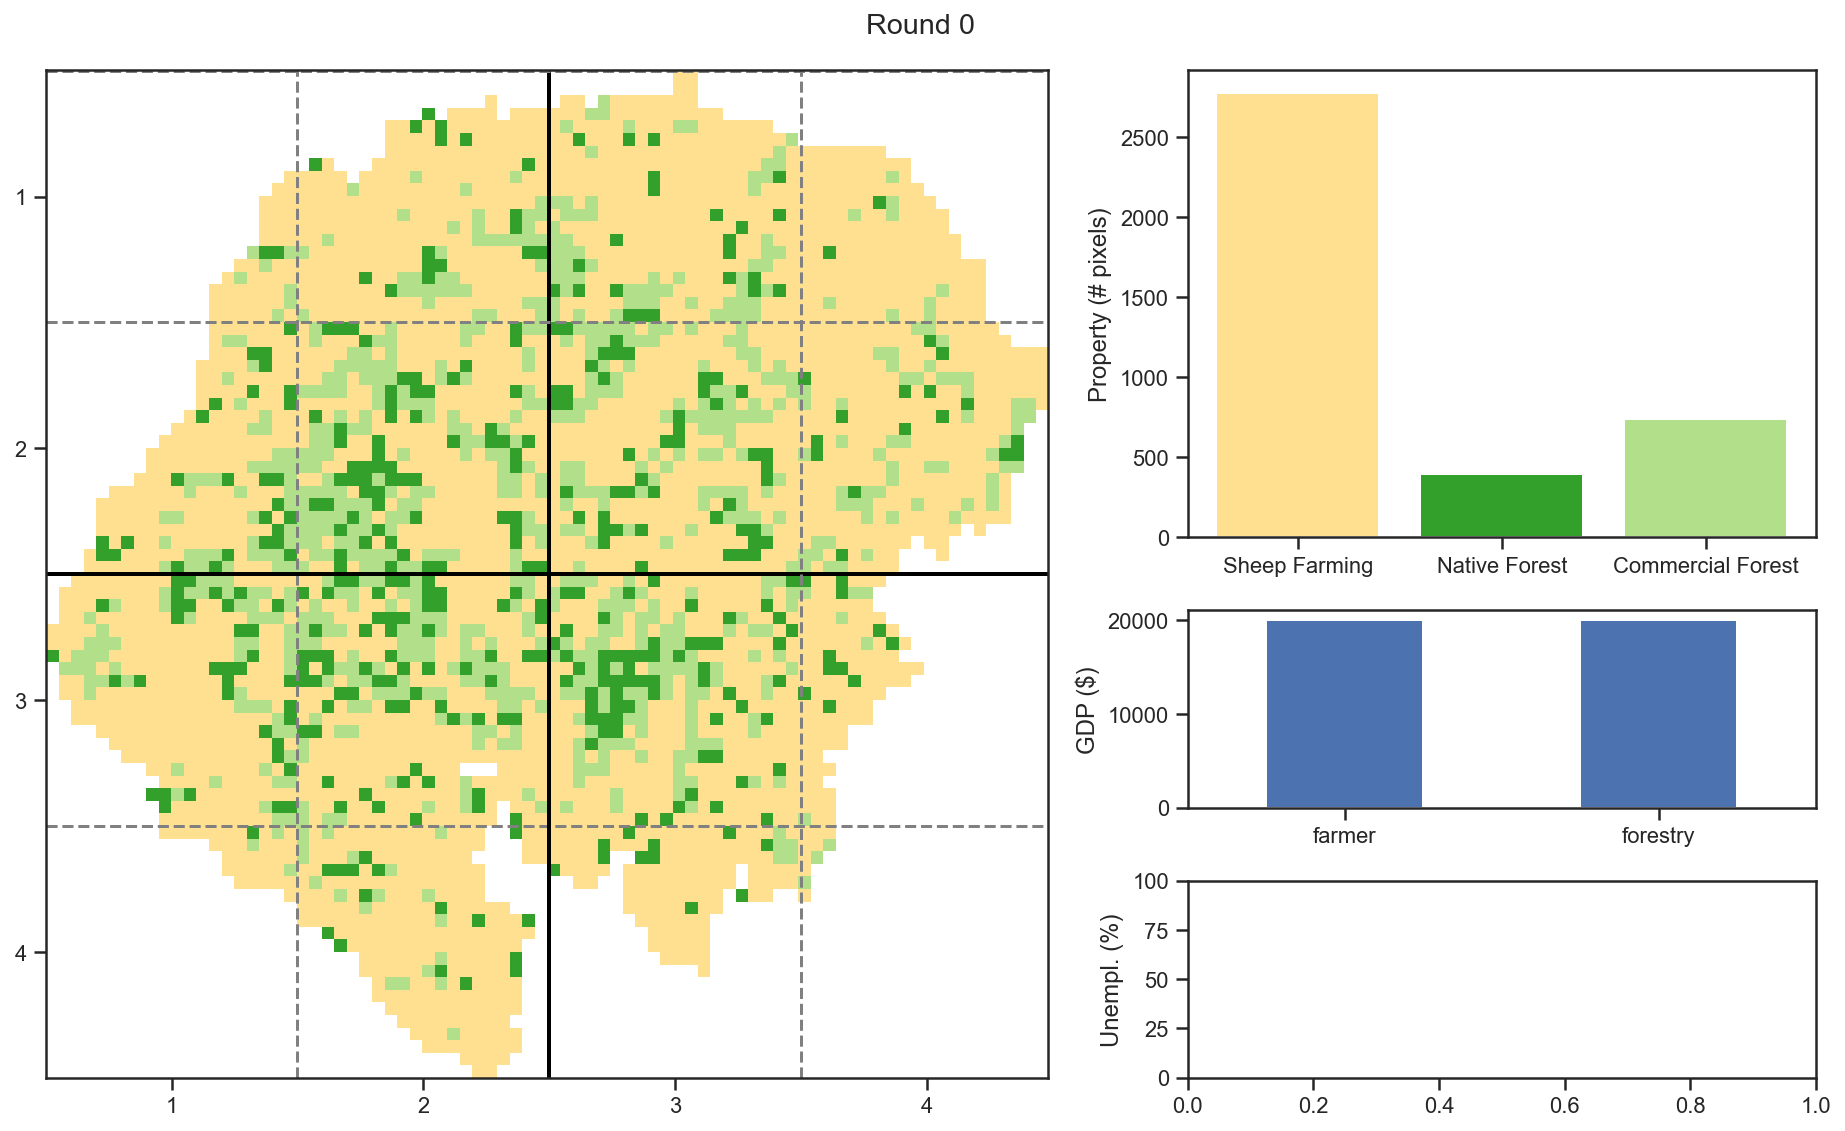

In [12]:
%reload_ext autoreload
matrix_game.show_dashboard(figure_size=(13,8))

#### Assign property rights

In [13]:
%reload_ext autoreload
matrix_game.block_definition_matrix_pixel_lvl

array([[11., 11., 11., ..., 14., 14., 14.],
       [11., 11., 11., ..., 14., 14., 14.],
       [11., 11., 11., ..., 14., 14., 14.],
       ...,
       [41., 41., 41., ..., 44., 44., 44.],
       [41., 41., 41., ..., 44., 44., 44.],
       [41., 41., 41., ..., 44., 44., 44.]])

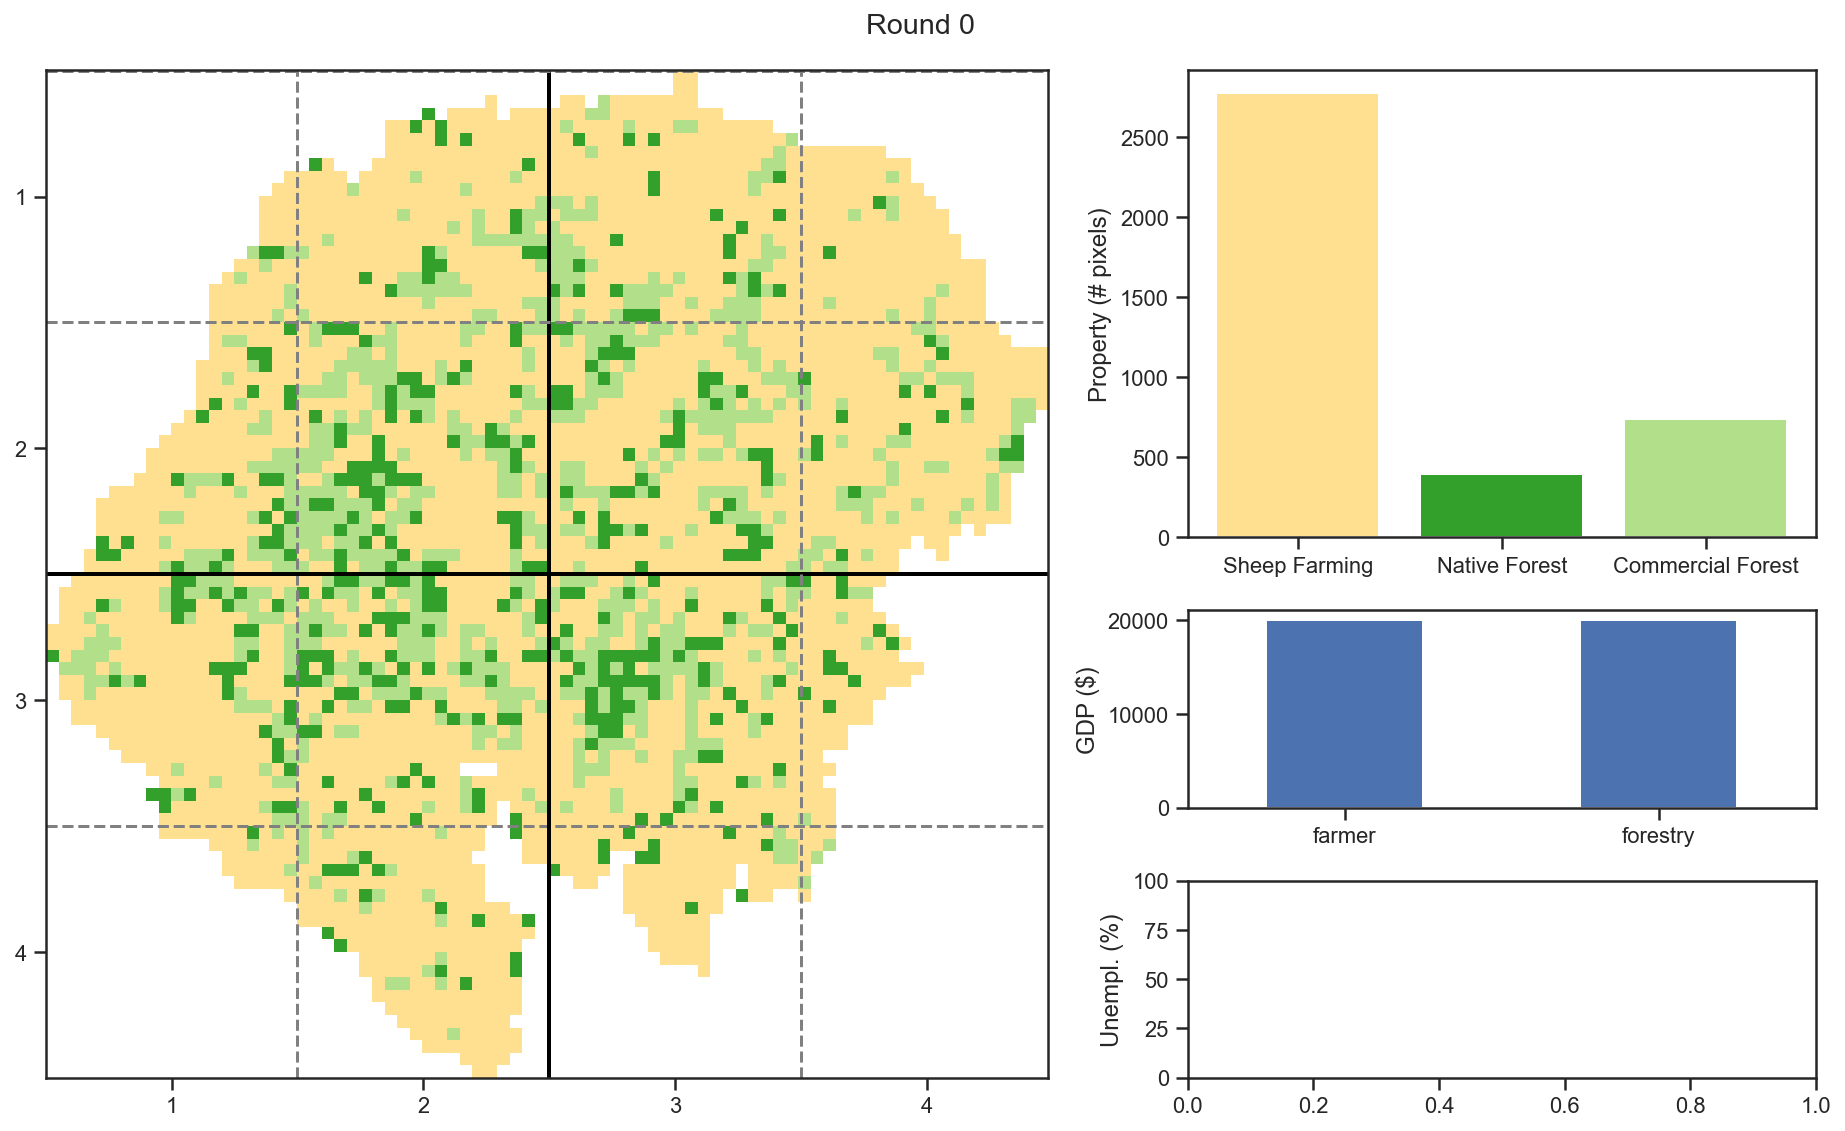

In [14]:
%reload_ext autoreload
matrix_game.show_dashboard(figure_size=(13,8), property_rights=True)

### Round 1

#### 1. Downloading management decisions

In [15]:
%%time
%reload_ext autoreload

# download mgmt decisions
matrix_game.fetch_mgmt_decisions()

Farmer_1
Farmer_2
Forester_1
Forester_2
SSDA
CPU times: user 888 ms, sys: 267 ms, total: 1.15 s
Wall time: 6.82 s


store in class

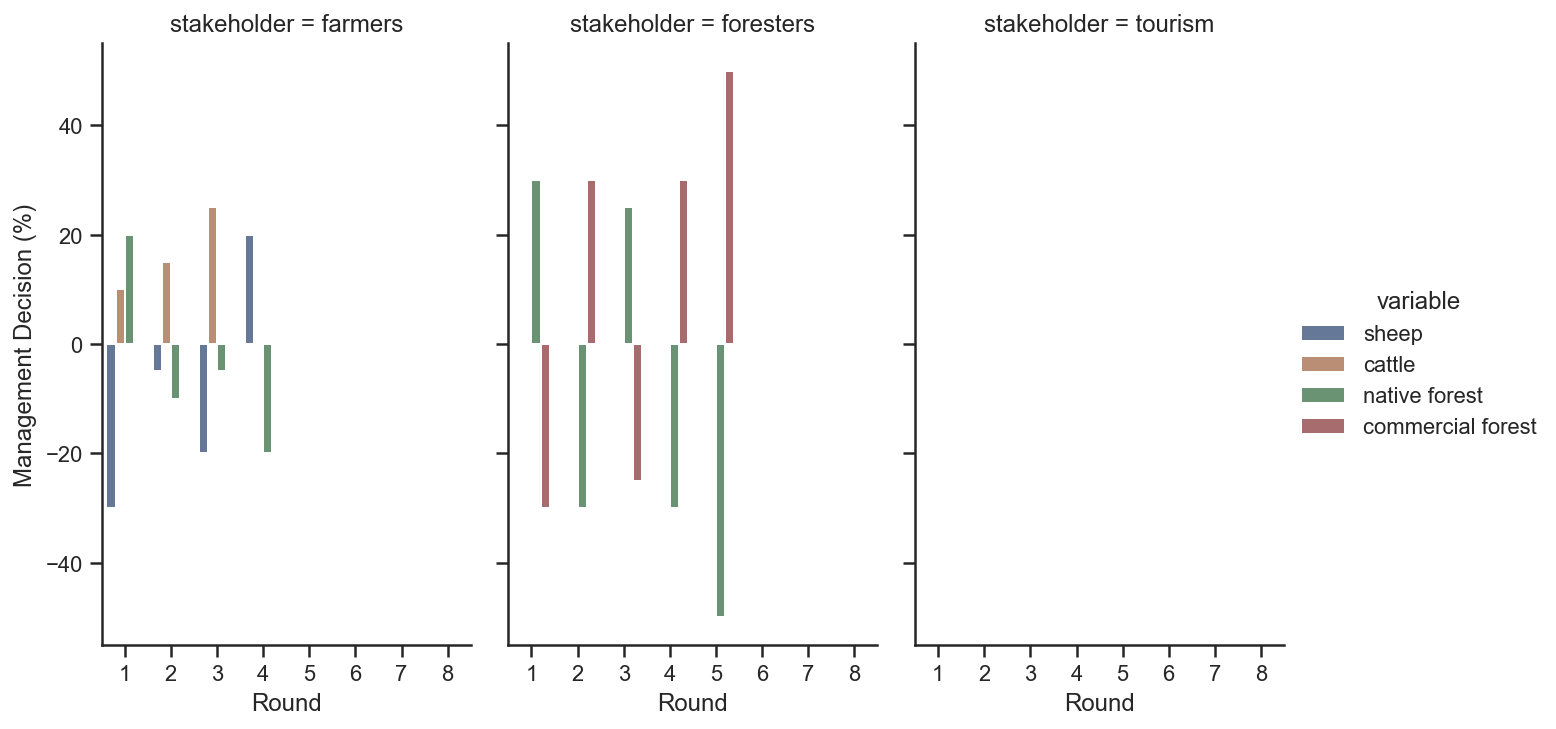

In [16]:
# visualize
matrix_game.show_all_mgmt_decisions()

In [37]:
matrix_game.df_mgmt_decisions_long

,stakeholder,round,player,plot,teamwork,variable,value
0,farmers,1,Farmer_1,21,False,sheep,-30.0
1,farmers,1,Farmer_2,24,False,sheep,-30.0
2,farmers,2,Farmer_1,31,False,sheep,-10.0
3,farmers,2,Farmer_2,32,False,sheep,0.0
4,farmers,3,Farmer_1,12,False,sheep,-50.0
...,...,...,...,...,...,...,...
155,tourism,4,SSDA,0,False,commercial forest,NaN
156,tourism,5,SSDA,0,False,commercial forest,NaN
157,tourism,6,SSDA,0,False,commercial forest,NaN
158,tourism,7,SSDA,0,False,commercial forest,NaN


In [48]:
matrix_game.df_mgmt_decisions_long.query("round == 1 & plot > 0")

,stakeholder,round,player,plot,teamwork,variable,value
0,farmers,1,Farmer_1,21,False,sheep,-30.0
1,farmers,1,Farmer_2,24,False,sheep,-30.0
16,foresters,1,Forester_1,31,False,sheep,NaN
32,tourism,1,SSDA,14,False,sheep,NaN
40,farmers,1,Farmer_1,21,False,cattle,0.0
41,farmers,1,Farmer_2,24,False,cattle,20.0
56,foresters,1,Forester_1,31,False,cattle,NaN
72,tourism,1,SSDA,14,False,cattle,NaN
80,farmers,1,Farmer_1,21,False,native forest,30.0
81,farmers,1,Farmer_2,24,False,native forest,10.0


#### Masking individual plots is functional! (:

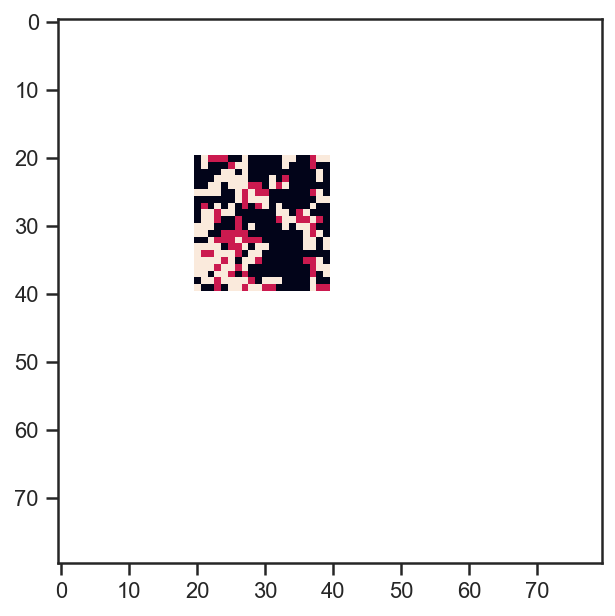

In [91]:
plot = 22
mgmt_mask = (matrix_game.block_definition_matrix_pixel_lvl == plot)
np.unique(mgmt_mask, return_counts=True)

ar = matrix_game.lulc_matrix_stack[:, :, 0].copy()
ar_masked = np.ma.masked_where(~mgmt_mask, ar.data, copy=True)
plt.imshow(ar_masked)

In [90]:
%reload_ext autoreload
matrix_game.block_definition_matrix_pixel_lvl

array([[11., 11., 11., ..., 14., 14., 14.],
       [11., 11., 11., ..., 14., 14., 14.],
       [11., 11., 11., ..., 14., 14., 14.],
       ...,
       [41., 41., 41., ..., 44., 44., 44.],
       [41., 41., 41., ..., 44., 44., 44.],
       [41., 41., 41., ..., 44., 44., 44.]])

#### 2. Calculating Income & updating Bank Accounts

In [19]:
# TODO: MARTINA

#### 3. Updating dashboard (reflect changes in landscape, property allocation, GDP and unemployment)

In [20]:
%reload_ext autoreload
# TODO: FELIX


# access round 0 data
matrix_game.lulc_matrix_stack[:,:,0]

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=255,
  dtype=uint8)

In [26]:
dicts.stakeholder_id_dict

{'Farmer_1': 100,
 'Farmer_2': 110,
 'Forester_1': 120,
 'Forester_2': 130,
 'SSDA': 150}

In [27]:
matrix_game.block_definition_matrix_pixel_lvl

array([[11., 11., 11., ..., 14., 14., 14.],
       [11., 11., 11., ..., 14., 14., 14.],
       [11., 11., 11., ..., 14., 14., 14.],
       ...,
       [41., 41., 41., ..., 44., 44., 44.],
       [41., 41., 41., ..., 44., 44., 44.],
       [41., 41., 41., ..., 44., 44., 44.]])

In [25]:
matrix_game.property_rights_matrix

array([[100., 100., 100., ..., 120., 120., 120.],
       [100., 100., 100., ..., 120., 120., 120.],
       [100., 100., 100., ..., 120., 120., 120.],
       ...,
       [130., 130., 130., ..., 110., 110., 110.],
       [130., 130., 130., ..., 110., 110., 110.],
       [130., 130., 130., ..., 110., 110., 110.]])

#### 4. Updating round number

In [22]:
%reload_ext autoreload
matrix_game.update_round_number()

## Round 2

#### 0. Sanity check on round number

In [23]:
%reload_ext autoreload
assert matrix_game.get_rounds(True) == 1

#### 1. Downloading management decisions

## Round 3

# Code graveyard

#### Yield calculation

In [24]:
%reload_ext autoreload
# transform dicts & data frame data
# global_yield_remapped = dict(zip(matrix_game.simplified_lulc_mapping.keys(), list(global_yield.values())))
# df_global_yield_remapped = pd.DataFrame(global_yield_remapped, index=["yield"]).transpose()